In [53]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import *

from gammapy.estimators import FluxPointsEstimator


In [73]:
# Define simulation parameters parameters
livetime = 30 * u.h

pointing_position = SkyCoord(0, 0, unit="deg", frame="galactic")
# We want to simulate an observation pointing at a fixed position in the sky.
# For this, we use the `FixedPointingInfo` class
pointing = FixedPointingInfo(
    fixed_icrs=pointing_position.icrs,
)
offset = 0.5 * u.deg

# Reconstructed and true energy axis
energy_axis = MapAxis.from_energy_bounds(0.1, 50, nbin=10, per_decade=True, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.02, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true")


on_region_radius = Angle("0.11 deg")

center = pointing_position.directional_offset_by(
    position_angle=0 * u.deg, separation=offset
)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)


In [74]:
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

location = observatory_locations["ctao_south"]
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [75]:
# Make the SpectrumDataset
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="obs-0"
)
maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

dataset = maker.run(dataset_empty, obs)

In [76]:
ExpCutoffPowerLawSpectralModel()

In [77]:
# Define spectral model - a simple Power Law in this case
spec =ExpCutoffPowerLawSpectralModel(
    amplitude = 1e-13 * u.Unit("cm-2 s-1 TeV-1"),
    index=3.0,
    lambda_=0.1 / u.TeV,
    reference = 1 * u.TeV
)
spec.amplitude.min = 0.0
spec.index.max=8.0
model_simu = SkyModel(spectral_model=spec, name="simulated")

In [78]:
spec.e_peak

<Quantity nan TeV>

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

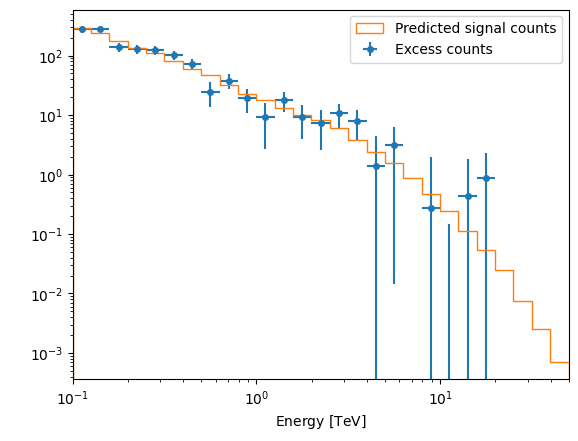

In [79]:
dataset.models = model_simu
dataset.fake()
dataset.plot_excess()

In [80]:
model_dl4 = model_simu.copy(name="dl4")

In [81]:
dataset.models = model_dl4
fit=Fit()
res = fit.run(dataset)

In [82]:
energy_axis

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 27        
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges max  : 5.0e+01 TeV
	interp     : log

In [83]:
%%time
energy_edges = energy_axis.edges  # you can also manually set custom edges

fpe = FluxPointsEstimator(
    energy_edges=energy_axis.downsample(3).edges,
    source="dl4",  # name of your model
    selection_optional="all",
    n_jobs=6
)

flux_points = fpe.run(datasets=dataset)


CPU times: user 62.4 ms, sys: 154 ms, total: 217 ms
Wall time: 4.08 s


In [84]:
from gammapy.datasets import FluxPointsDataset
flux_points_dataset=FluxPointsDataset(data=flux_points,name="fpe_ds")

In [85]:
model_dl5 = model_simu.copy(name="dl5")
flux_points_dataset.models= model_dl5 

In [86]:
res2 = fit.run(flux_points_dataset)

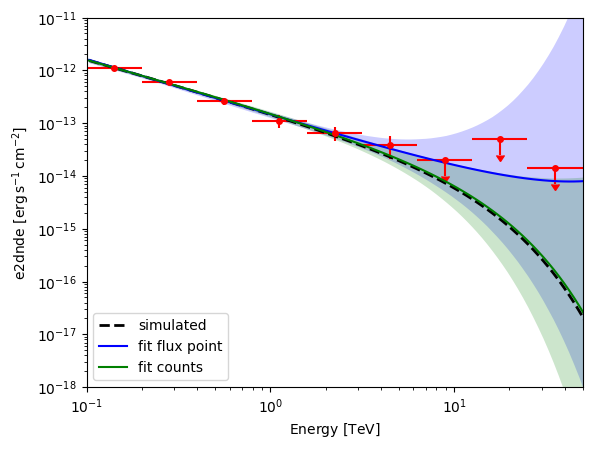

In [87]:
energy_bounds = (0.1, 60) *u.TeV

flux_points.plot(sed_type="e2dnde",color="red")
model_simu.spectral_model.plot(energy_bounds=energy_bounds, sed_type="e2dnde",color='black',label="simulated",ls="--", lw=2)

model_dl5.spectral_model.plot(energy_bounds=energy_bounds, sed_type="e2dnde",color='blue',label="fit flux point")
model_dl5.spectral_model.plot_error(energy_bounds=energy_bounds, sed_type="e2dnde",facecolor='blue')

model_dl4.spectral_model.plot(energy_bounds=energy_bounds, sed_type="e2dnde",color='green',label="fit counts")
model_dl4.spectral_model.plot_error(energy_bounds=energy_bounds, sed_type="e2dnde",facecolor='green')

plt.ylim(1e-18,1e-11)
plt.legend()

In [88]:
from tqdm import tqdm

In [162]:
n_obs = 100
res_dl4 = []
res_dl5 = []
fpe = FluxPointsEstimator(
    energy_edges=energy_axis.downsample(3).edges,
    n_jobs=6
)
for idx in tqdm(range(n_obs)):
    dataset.models = model_simu
    dataset.fake()
    model_dl4=model_simu.copy()
    model_dl4.parameters["lambda_"].value=0.2
    model_dl4.parameters["index"].value=2.0
    model_dl4.parameters["lambda_"].max=3.0
    dataset.models = model_dl4
    res_dl4.append(fit.run(dataset))
    fp = fpe.run(dataset)
    model_dl5 = model_simu.copy()
    model_dl5.parameters["lambda_"].value=0.2
    model_dl5.parameters["index"].value=2.0
    model_dl5.parameters["lambda_"].max=3.0
    fp_ds = FluxPointsDataset(data=fp,name="fpe_ds")
    fp_ds.models = model_dl5
    res_dl5.append(fit.run(fp_ds))
    



 10%|████▏                                     | 10/100 [00:22<03:21,  2.24s/it]/home/atreyeesinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:375: RuntimeWarning: overflow encountered in square
  return ((data - model) / sigma).to_value("") ** 2
 12%|█████                                     | 12/100 [00:25<02:38,  1.80s/it]/home/atreyeesinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:375: RuntimeWarning: overflow encountered in square
  return ((data - model) / sigma).to_value("") ** 2
 18%|███████▌                                  | 18/100 [00:37<02:58,  2.18s/it]/home/atreyeesinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:375: RuntimeWarning: overflow encountered in square
  return ((data - model) / sigma).to_value("") ** 2
 43%|██████████████████                        | 43/100 [01:28<01:42,  1.81s/it]/home/atreyeesinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:375: RuntimeWarning: overflow encountered in square
  return ((data - model) / sigma

In [163]:
from astropy.table import QTable

In [164]:
def create_table(fit_result):
    t = QTable()
    t["convergence"] = [result.success for result in fit_result]
    for par in fit_result[0].models.parameters.free_parameters:
        t[par.name] = [
            result.models.parameters[par.name].value * par.unit for result in fit_result
        ]
        t[par.name + "_err"] = [
            result.models.parameters[par.name].error * par.unit for result in fit_result
        ]
    return t


table_dl4 = create_table(res_dl4)
table_dl5 = create_table(res_dl5)


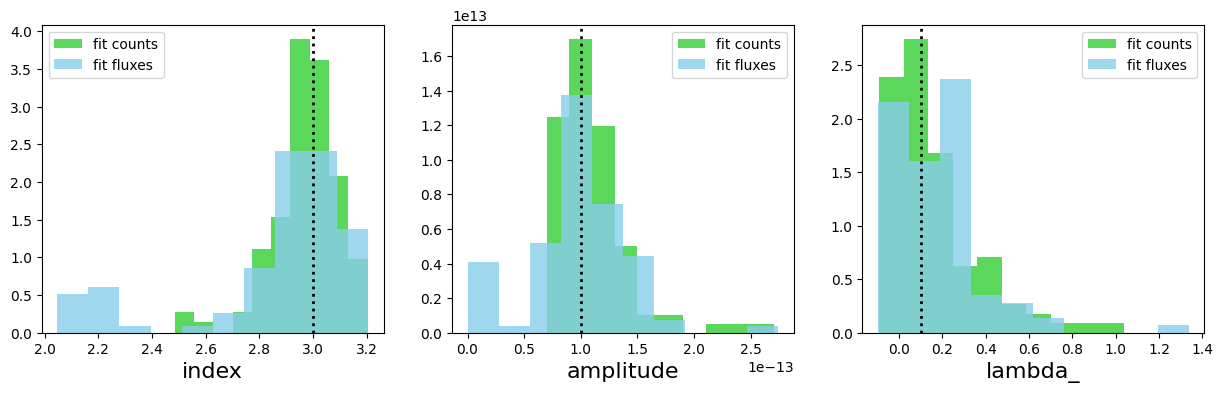

In [165]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

pars = res_dl4[0].models.parameters.free_parameters.names
for i in range(len(pars)):
    axes[i].hist(table_dl4[pars[i]][~np.isinf(table_dl4[pars[i]])].value, bins=10, alpha=0.8, color='limegreen', 
                 density=True, label="fit counts")
    axes[i].hist(table_dl5[pars[i]][~np.isinf(table_dl5[pars[i]])].value, bins=10, alpha=0.8, color='skyblue', 
                 density=True, label="fit fluxes")
    
    axes[i].axvline(x=model_simu.parameters[pars[i]].value, color='black', lw=2, ls="dotted")
    axes[i].set_xlabel(pars[i], fontsize=16)
    l1, l2 = min(table_dl4[pars[i]]), max(table_dl4[pars[i]])
    axes[i].legend()
    #axes[i].set_xlim(1.0*l1.value, 1.0*l2.value)


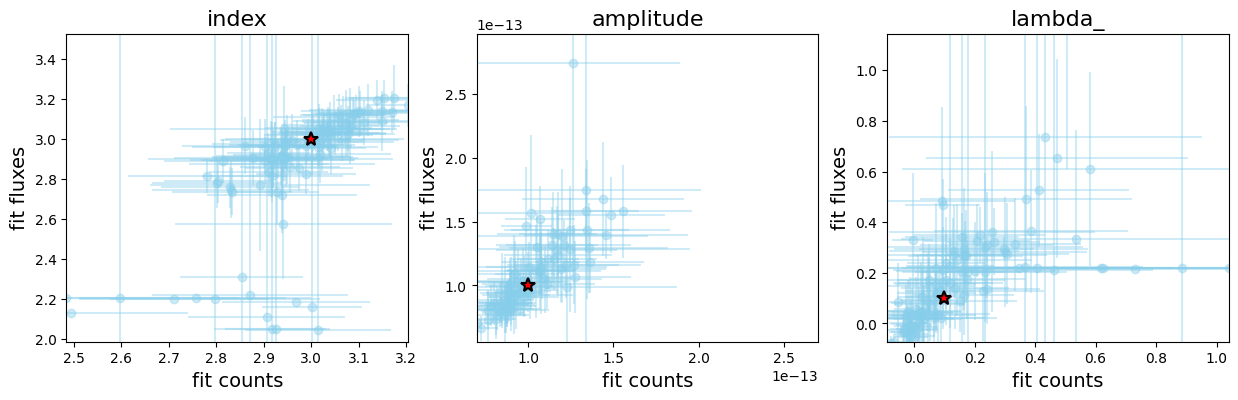

In [166]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

pars = res_dl4[0].models.parameters.free_parameters.names
for i in range(len(pars)):
    axes[i].plot([model_simu.parameters[pars[i]].value], [model_simu.parameters[pars[i]].value], marker="*", color="red",
                 markersize=10, alpha=1)
    axes[i].errorbar(x=table_dl4[pars[i]], y=table_dl5[pars[i]], xerr=table_dl4[pars[i]+"_err"],yerr=table_dl5[pars[i]+"_err"], 
                     fmt="o", color="skyblue", alpha=0.4 )
    l1, l2 = min(table_dl4[pars[i]]), max(table_dl4[pars[i]])
    #axes[i].plot(np.linspace(l1,l2),np.linspace(l1,l2) )
    axes[i].set_title(pars[i], fontsize=16)
    axes[i].set_xlabel("fit counts", fontsize=14)
    axes[i].set_ylabel("fit fluxes", fontsize=14)
    axes[i].plot([model_simu.parameters[pars[i]].value], [model_simu.parameters[pars[i]].value], marker="*", color="red",
                 markersize=10, alpha=1, markeredgecolor="black", markeredgewidth=1.5, zorder=10)
    axes[i].set_ylim(0.8*l1.value, 1.1*l2.value)
    axes[i].set_xlim(1.0*l1.value, 1.0*l2.value)